In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v5.3.2_remission_rate_changes/ciff_sam/2022_01_28_17_10_48/count_data/'

In [3]:
figname = 'model_5.3.2'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'wasting_transition_count.csv',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,death,29,baseline,1.0,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,death,29,baseline,0.0,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,death,29,baseline,0.0,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,death,29,baseline,0.0,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,death,29,baseline,2.0,susceptible_to_child_wasting,late_neonatal


In [6]:
groupby_cols = ['input_draw','wasting_state']

In [7]:
def calculate_transition_rates(groupby_cols):
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [8]:
def calculate_incidence_rrs(strata_cols):
    t = calculate_transition_rates(strata_cols + ['input_draw','wasting_state']).reset_index()
    t = t.loc[t.measure=='incidence']
    tmrel = t.loc[t.wasting_state=='susceptible_to_child_wasting'].set_index(strata_cols + ['input_draw','cause'])[['value']]
    t = t.set_index(strata_cols + ['input_draw','cause','wasting_state'])[['value']] / tmrel
    t = t.groupby(strata_cols + ['cause','wasting_state']).describe(percentiles=[0.025,0.975])
    return t

In [9]:
calculate_incidence_rrs([])

<ipython-input-7-260d15d67c09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
<ipython-input-7-260d15d67c09>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')


value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            12.0  1.005835   
                             moderate_acute_malnutrition   12.0  1.036524   
                             severe_acute_malnutrition     12.0  1.108369   
                             susceptible_to_child_wasting  12.0  1.000000   
lower_respiratory_infections mild_child_wasting            12.0  1.850507   
                             moderate_acute_malnutrition   12.0  4.154680   
                             severe_acute_malnutrition     12.0  8.105834   
                             susceptible_to_child_wasting  12.0  1.000000   
measles                      mild_child_wasting            12.0  1.063654   
                             moderate_acute_malnutrition   12.0  2.458000   
                             severe_acute_malnutrition     12.0  8.136188   
                             susceptible_to_child_wasting  12.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.003697  1.000051   
                             moderate_acute_malnutrition   0.007501  1.029612   
                             severe_acute_malnutrition     0.020586  1.081131   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.342750  1.360692   
                             moderate_acute_malnutrition   0.896816  2.849575   
                             severe_acute_malnutrition     2.162037  5.347551   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.162406  0.864310   
                             moderate_acute_malnutrition   0.452596  1.651420   
                             severe_acute_malnutrition     2.396806  4.773613   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                               2.5%       50%   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.000596  1.006356   
                             moderate_acute_malnutrition   1.029748  1.033273   
                             severe_acute_malnutrition     1.083019  1.103204   
                             susceptible_to_child_wasting  1.000000  1.000000   
lower_respiratory_infections mild_child_wasting            1.386168  1.777747   
                             moderate_acute_malnutrition   2.876052  4.040177   
                             severe_acute_malnutrition     5.349343  8.131635   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.872871  1.037711   
                             moderate_acute_malnutrition   1.683718  2.512852   
                             severe_acute_malnutrition     5.079216  7.782838   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                      \
                                                               97.5%   
cause                        wasting_state                             
diarrheal_diseases           mild_child_wasting             1.010169   
                             moderate_acute_malnutrition    1.050776   
                             severe_acute_malnutrition      1.150291   
                             susceptib

In [10]:
incidence_rrs = calculate_incidence_rrs(['age','sex'])
incidence_rrs

<ipython-input-7-260d15d67c09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
<ipython-input-7-260d15d67c09>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')


value  \
                                                                               count   
age           sex    cause                        wasting_state                        
1-5_months    female diarrheal_diseases           mild_child_wasting            12.0   
                                                  moderate_acute_malnutrition   12.0   
                                                  severe_acute_malnutrition     12.0   
                                                  susceptible_to_child_wasting  12.0   
                     lower_respiratory_infections mild_child_wasting            12.0   
...                                                                              ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  12.0   
                     measles                      mild_child_wasting             0.0   
                                                  moderate_acute_malnutrition    0.0   
                                                  severe_acute_malnutrition      0.0   
                                                  susceptible_to_child_wasting   0.0   

                                                                                          \
                                                                                    mean   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            1.008283   
                                                  moderate_acute_malnutrition   1.004813   
                                                  severe_acute_malnutrition     0.991775   
                                                  susceptible_to_child_wasting  1.000000   
                     lower_respiratory_infections mild_child_wasting            1.014113   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     std   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            0.012293   
                                                  moderate_acute_malnutrition   0.014570   
                                                  severe_acute_malnutrition     0.028215   
                                                  susceptible_to_child_wasting  0.000000   
                     lower_respiratory_infections mild_child_wasting            0.068680   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     min   
age           sex    cause                        wasting_state                     

In [11]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [12]:
wasting_rrs = art.load('risk_factor.child_wasting.relative_risk')

In [13]:
wasting_rrs = (art.load('risk_factor.child_wasting.relative_risk')
               .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
               .reset_index())
wasting_rrs['age'] = np.where(wasting_rrs['age_start'] == 0, 'early_neonatal', #1
                                            np.where(wasting_rrs['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(wasting_rrs['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(wasting_rrs['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(wasting_rrs['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2

wasting_rrs.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,count,mean,std,min,2.5%,50%,97.5%,max,age
0,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
1,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat2,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
2,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat3,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
3,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat4,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
4,Female,0.0,0.019178,2020,2021,lower_respiratory_infections,incidence_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal


In [28]:
def plot_incidence_relative_risks(age, sex, cause, measure):
    width=0.4
    if measure == 'incidence_rate':
        s = incidence_rrs.reset_index()
    elif measure == 'CSMR':
        s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

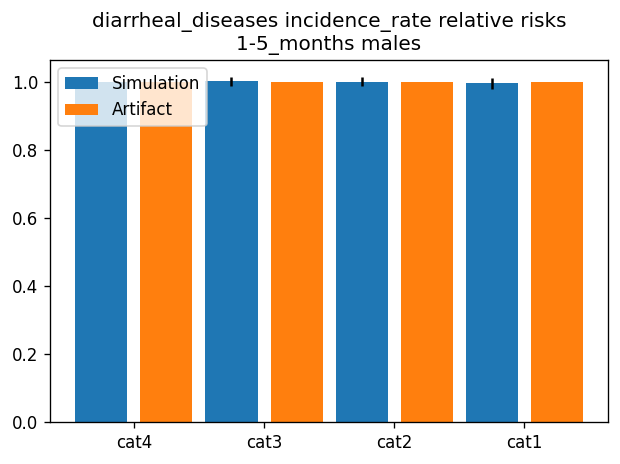

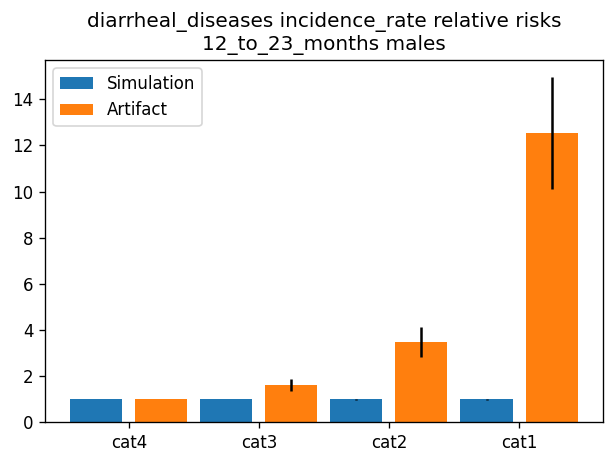

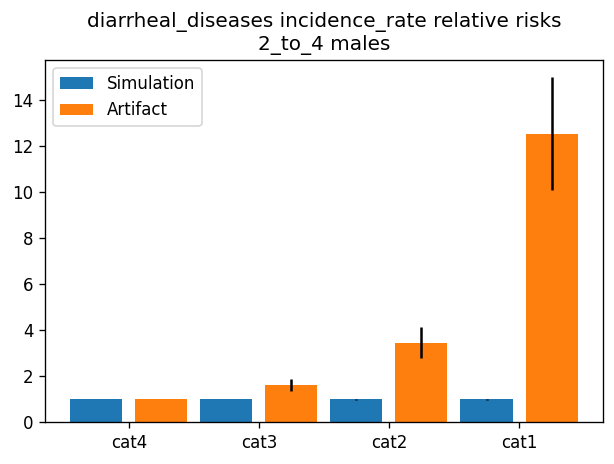

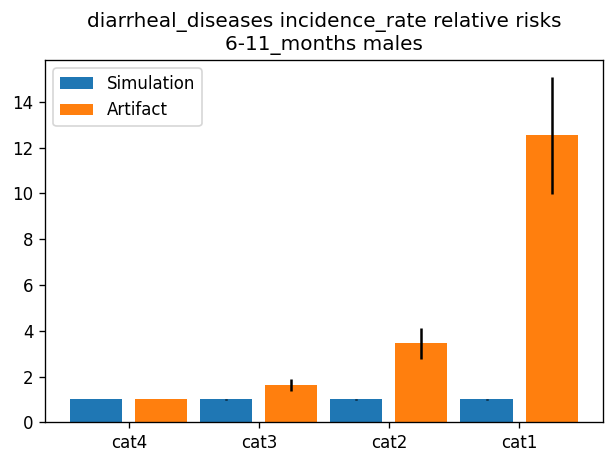

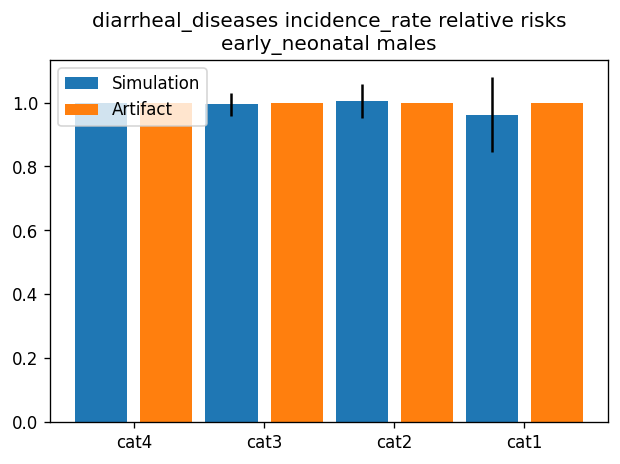

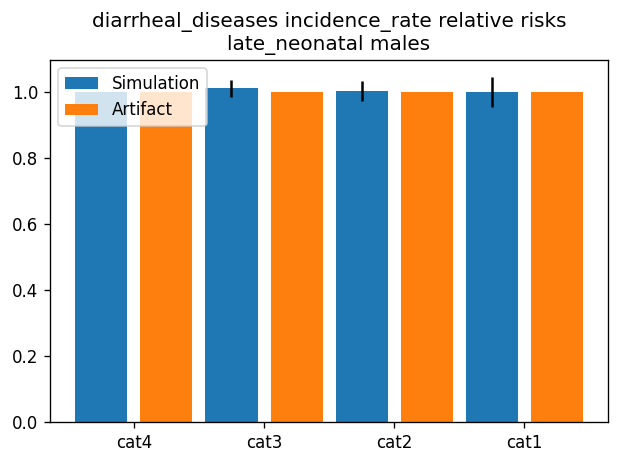

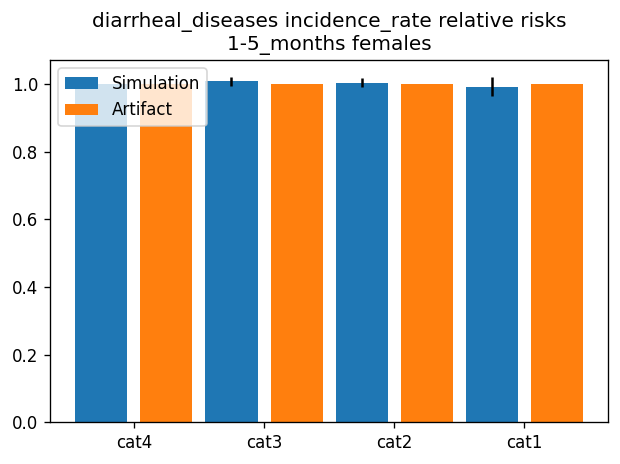

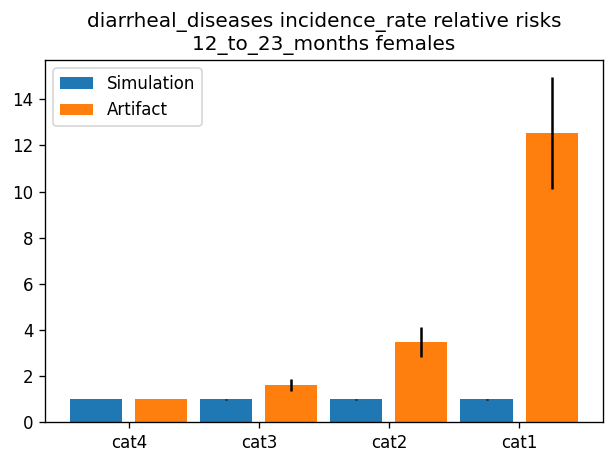

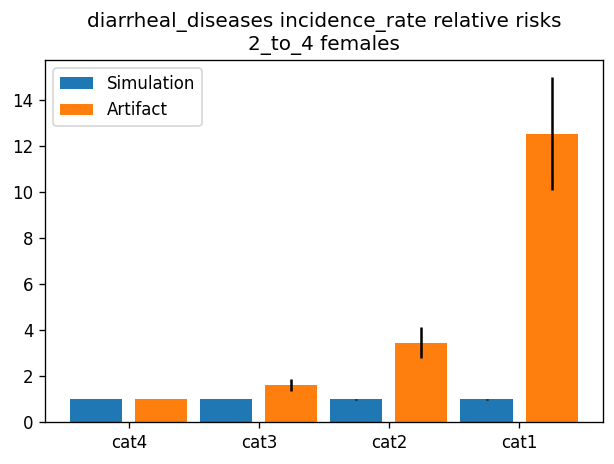

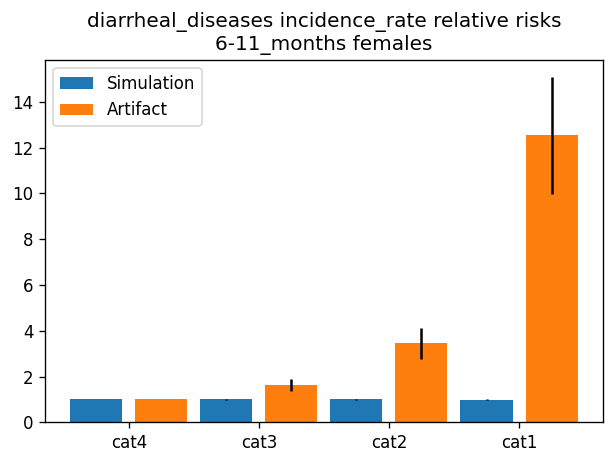

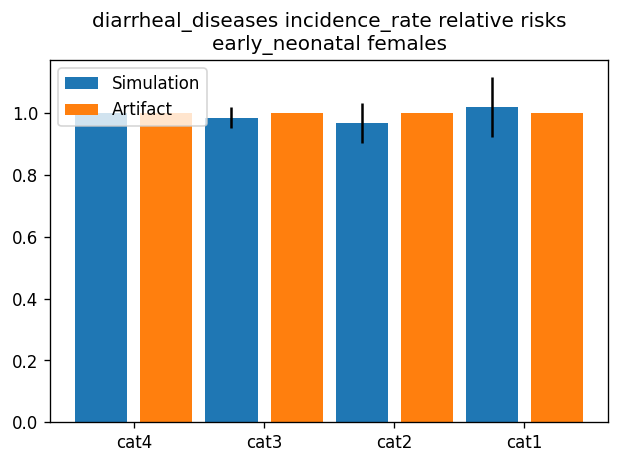

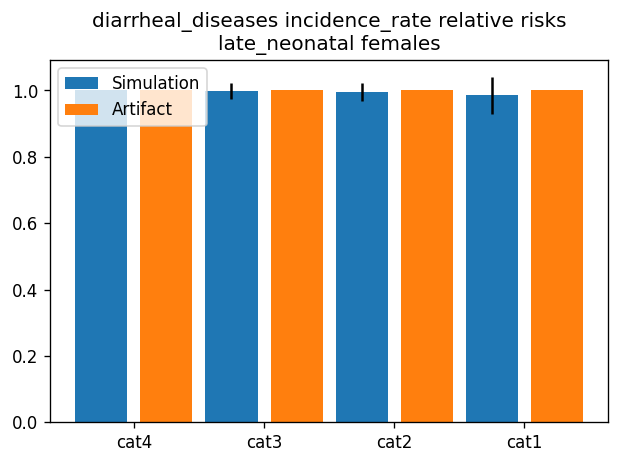

In [29]:
for sex in ['male','female']:
    for age in incidence_rrs.reset_index().age.unique():
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'incidence_rate')

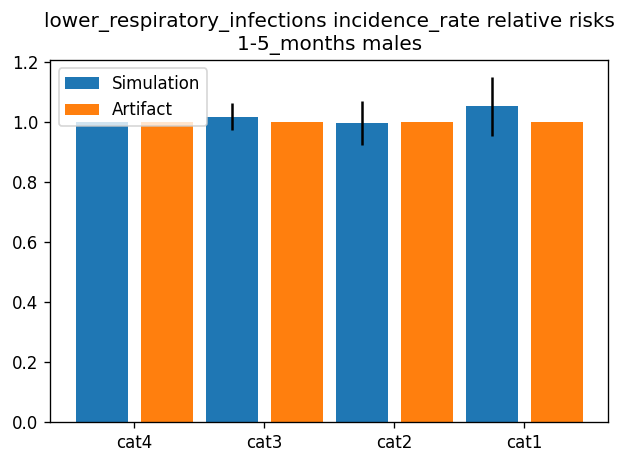

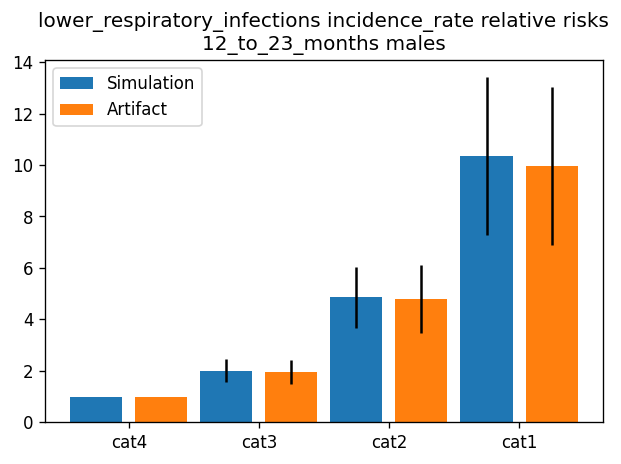

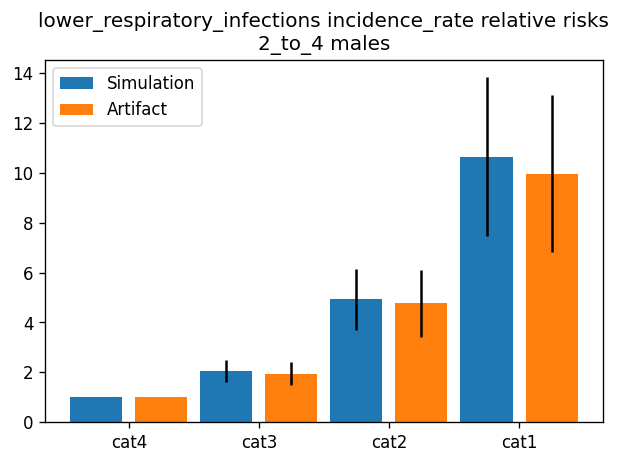

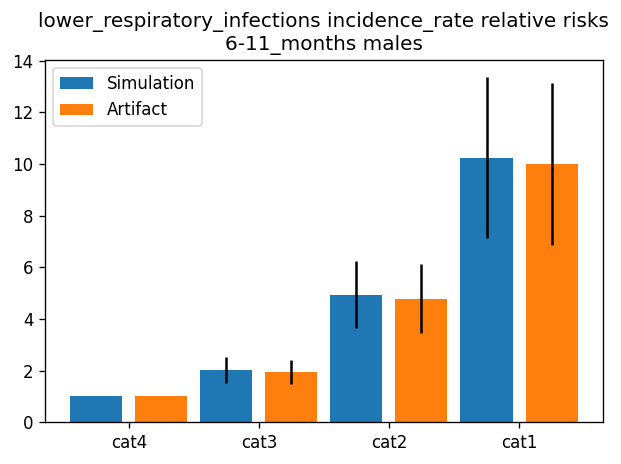

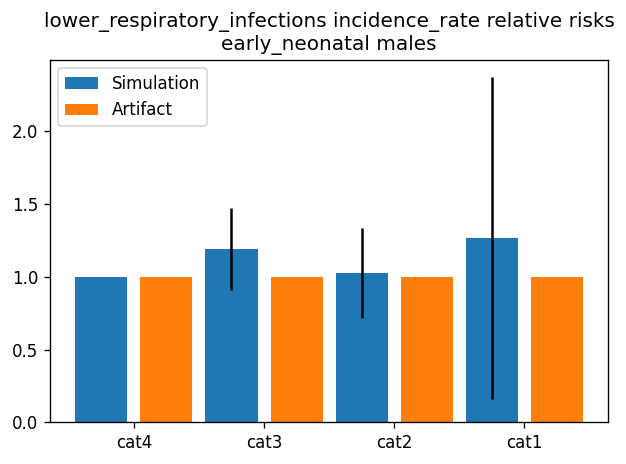

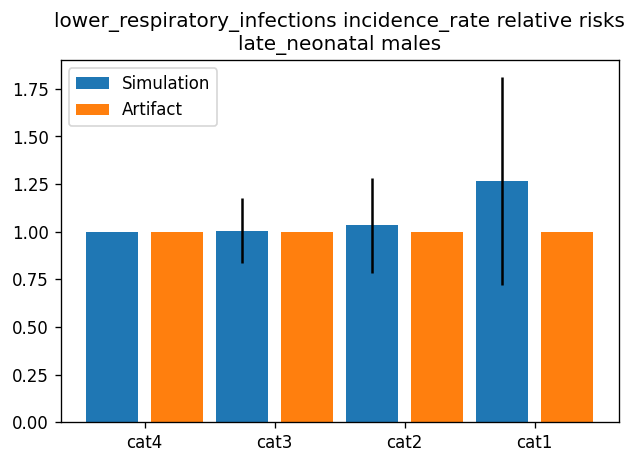

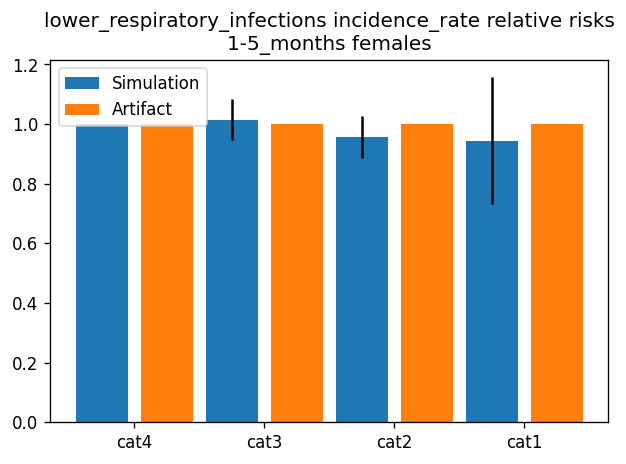

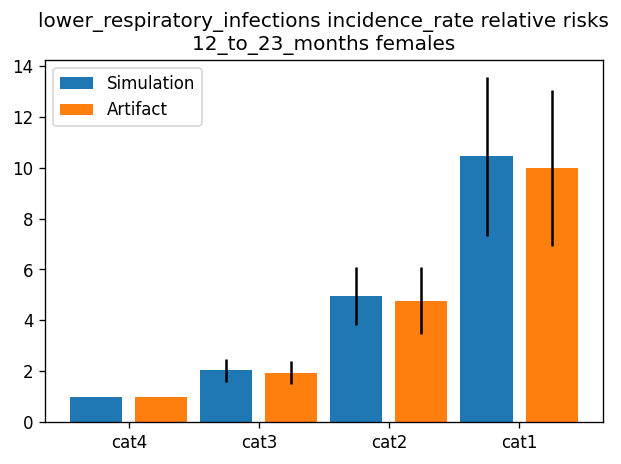

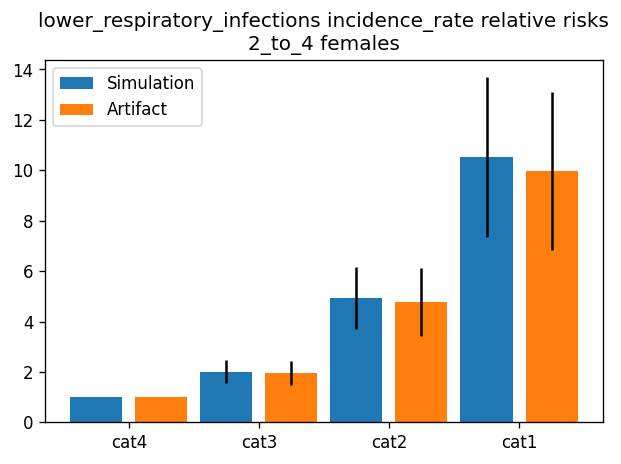

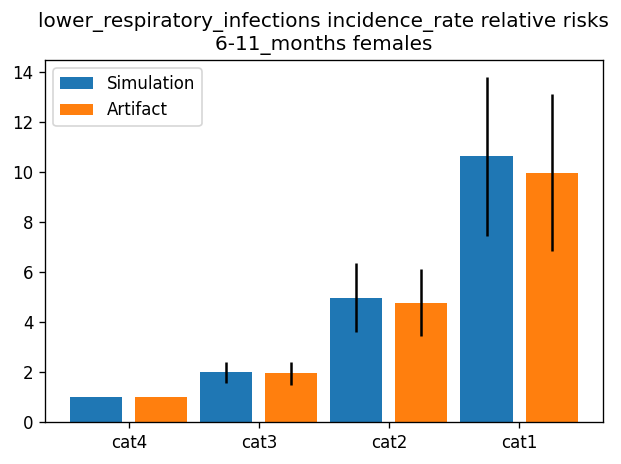

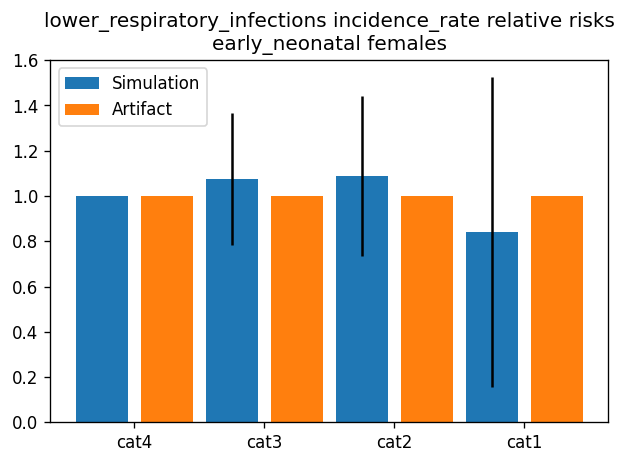

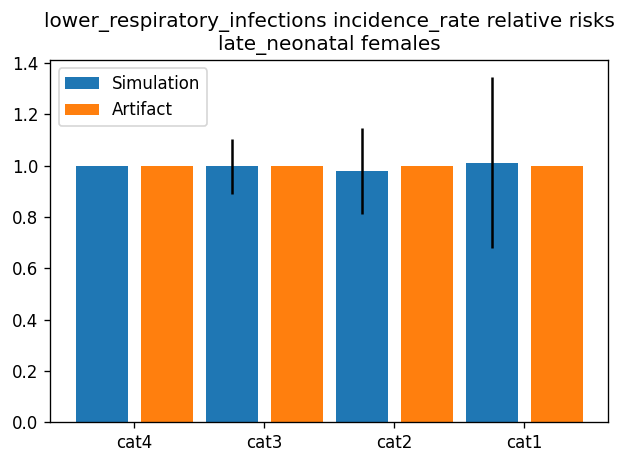

In [17]:
for sex in ['male','female']:
    for age in incidence_rrs.reset_index().age.unique():
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'incidence_rate')

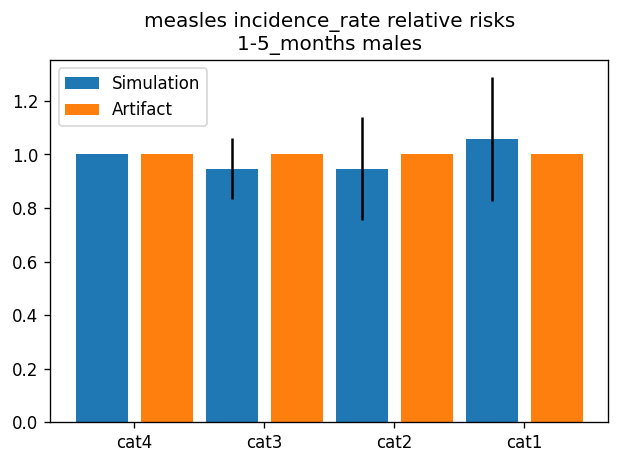

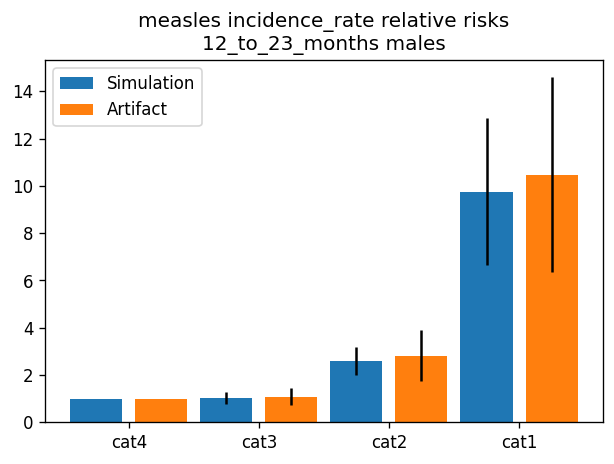

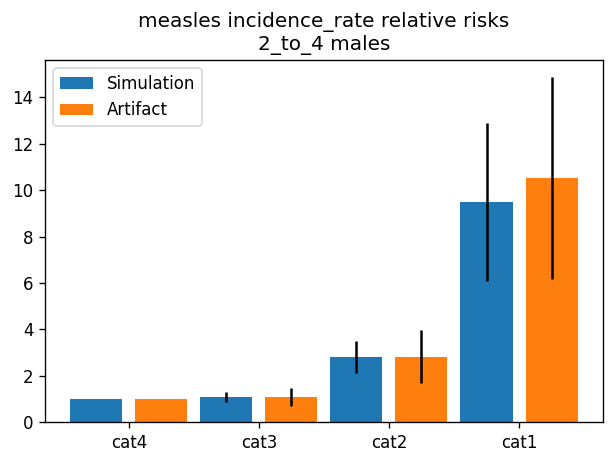

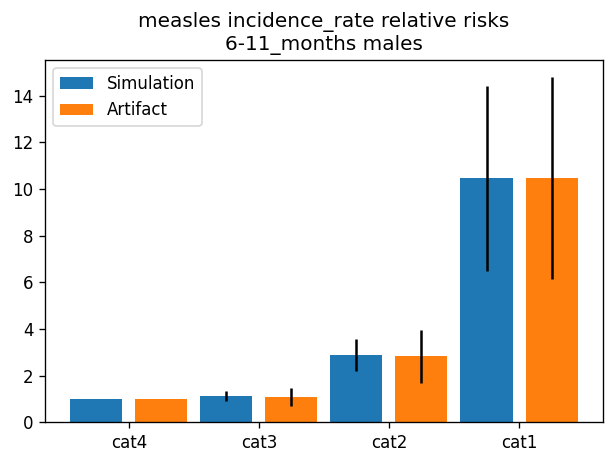

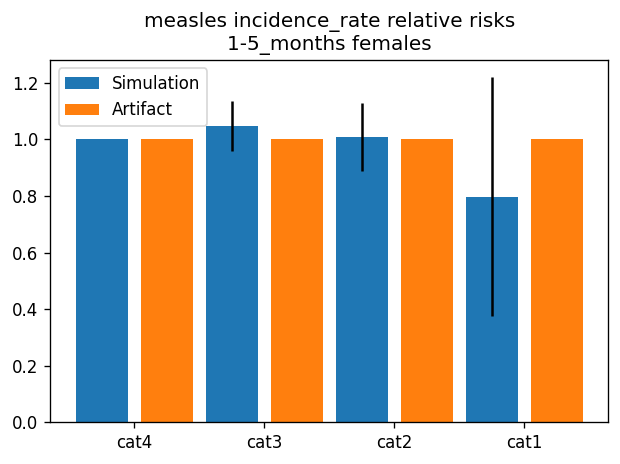

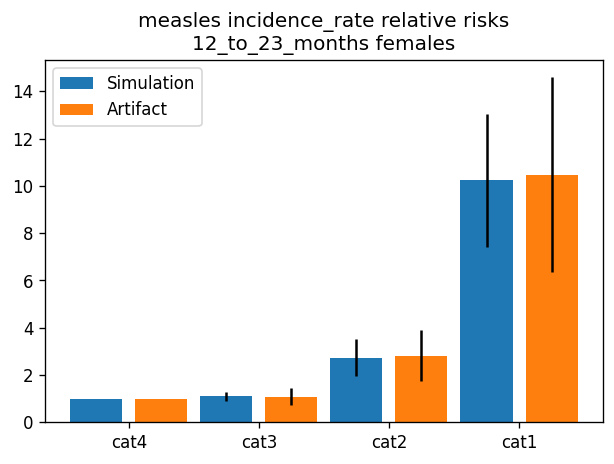

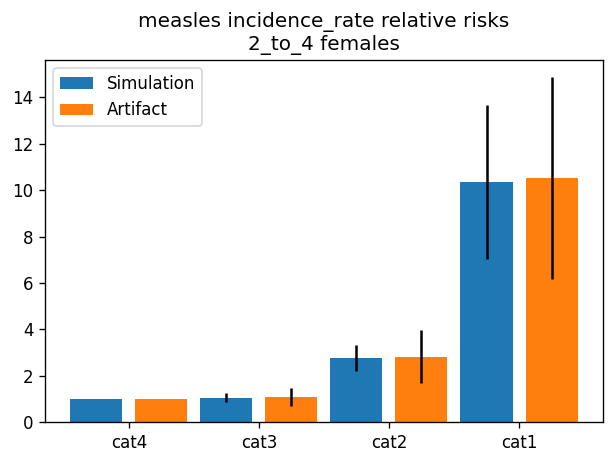

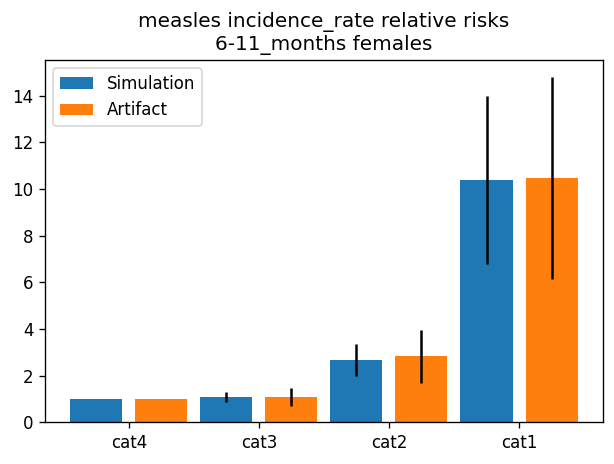

In [19]:
for sex in ['male','female']:
    for age in [a for a in incidence_rrs.reset_index().age.unique() if 'neonatal' not in a]:
            plot_incidence_relative_risks(age, sex, 'measles', 'incidence_rate')

In [21]:
def calculate_csmr_rrs(strata_cols):
    d = deaths.reset_index()
    d = d.loc[(d.scenario=='baseline')
             &(d.cause.isin(['diarrheal_diseases',
                            'lower_respiratory_infections',
                            'measles']))]
    d = d.groupby(strata_cols + ['input_draw','wasting_state','cause']).sum()[['value']]
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
              .loc[state_pt.scenario=='baseline']
              .groupby(strata_cols + ['input_draw','wasting_state']).sum())[['value']]
    d = (d / pt).reset_index()
    d_tmrel = d.loc[d.wasting_state.str.contains('susc')].set_index(strata_cols + ['input_draw','cause'])[['value']]
    d = d.set_index(strata_cols + ['input_draw','cause','wasting_state']) / d_tmrel
    d = d.groupby(strata_cols + ['cause','wasting_state']).describe()
    return d

In [22]:
calculate_csmr_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            12.0  1.482688   
                             moderate_acute_malnutrition   12.0  2.942402   
                             severe_acute_malnutrition     12.0  9.190997   
                             susceptible_to_child_wasting  12.0  1.000000   
lower_respiratory_infections mild_child_wasting            12.0  1.490000   
                             moderate_acute_malnutrition   12.0  3.046670   
                             severe_acute_malnutrition     12.0  6.201443   
                             susceptible_to_child_wasting  12.0  1.000000   
measles                      mild_child_wasting            12.0  0.958968   
                             moderate_acute_malnutrition   12.0  2.240682   
                             severe_acute_malnutrition     12.0  7.515744   
                             susceptible_to_child_wasting  12.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.292685  1.121928   
                             moderate_acute_malnutrition   0.779916  1.870641   
                             severe_acute_malnutrition     1.988093  7.183489   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.235853  1.152994   
                             moderate_acute_malnutrition   0.720544  1.685849   
                             severe_acute_malnutrition     1.153479  4.056764   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.351559  0.427098   
                             moderate_acute_malnutrition   1.027747  0.992641   
                             severe_acute_malnutrition     2.809098  2.103112   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                                25%       50%   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.270281  1.389906   
                             moderate_acute_malnutrition   2.288111  2.944205   
                             severe_acute_malnutrition     7.704343  8.665499   
                             susceptible_to_child_wasting  1.000000  1.000000   
lower_respiratory_infections mild_child_wasting            1.317667  1.452129   
                             moderate_acute_malnutrition   2.651215  3.207857   
                             severe_acute_malnutrition     5.438850  6.122107   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.783957  0.848682   
                             moderate_acute_malnutrition   1.426519  1.921872   
                             severe_acute_malnutrition     6.224045  7.571570   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                                
                                                                75%        max  
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.629626   2.002131  
                             moderate_acute_malnutrition   3.463306   4.306264  
                             severe_acute_malnutrition     9.8197

In [23]:
csmr_rrs = calculate_csmr_rrs(['age','sex'])
csmr_rrs.head()

value  \
                                                                            count   
age        sex    cause                        wasting_state                        
1-5_months female diarrheal_diseases           mild_child_wasting            12.0   
                                               moderate_acute_malnutrition   12.0   
                                               severe_acute_malnutrition     12.0   
                                               susceptible_to_child_wasting  12.0   
                  lower_respiratory_infections mild_child_wasting            12.0   

                                                                                       \
                                                                                 mean   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.117144   
                                               moderate_acute_malnutrition   1.207323   
                                               severe_acute_malnutrition     0.356211   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            1.029568   

                                                                                       \
                                                                                  std   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.337579   
                                               moderate_acute_malnutrition   0.352304   
                                               severe_acute_malnutrition     0.698157   
                                               susceptible_to_child_wasting  0.000000   
                  lower_respiratory_infections mild_child_wasting            0.312386   

                                                                                       \
                                                                                  min   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.620243   
                                               moderate_acute_malnutrition   0.529419   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.454497   

                                                                                       \
                                                                                  25%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.883961   
                                               moderate_acute_malnutrition   1.012367   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.757543   

                                                                                       \
                                                                                  50%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.074764   
                                               moderate_acute_malnutrition   1.280641   
                                               severe_acute_malnutrition     0.000000   
         

In [24]:
def plot_csmr_relative_risks(age, sex, cause, measure):
    width=0.4
    s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

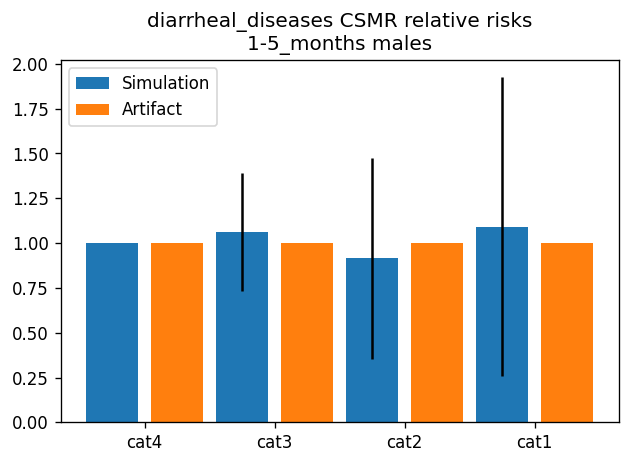

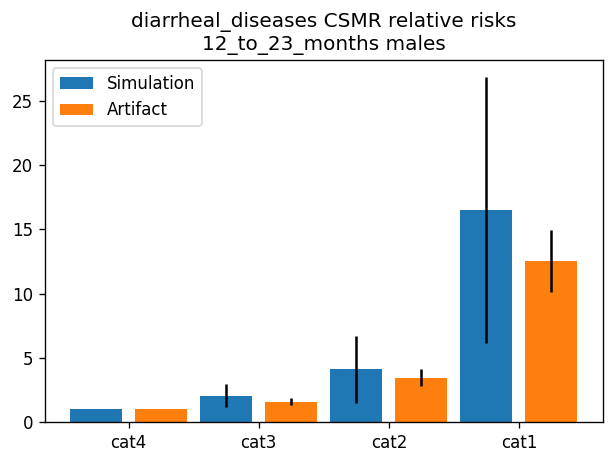

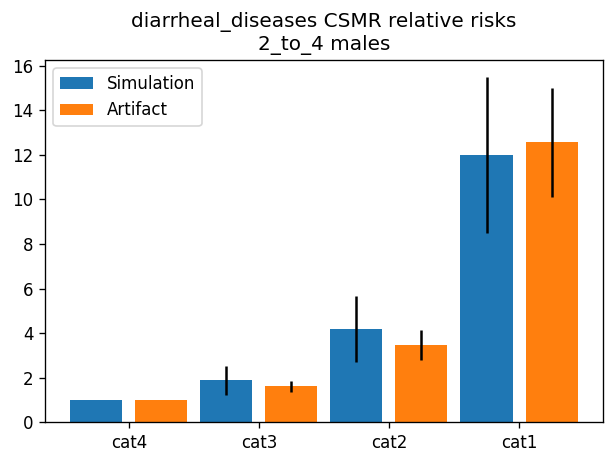

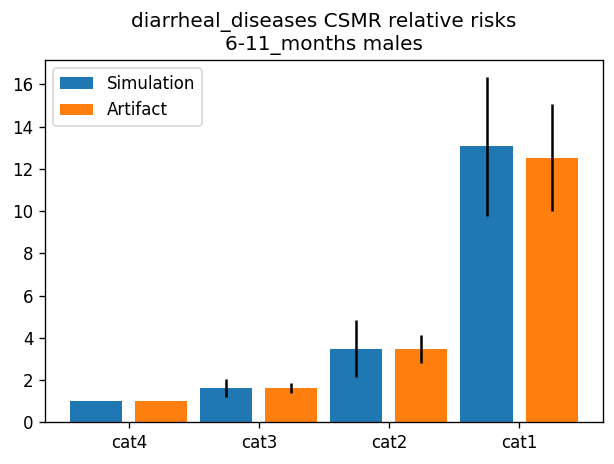

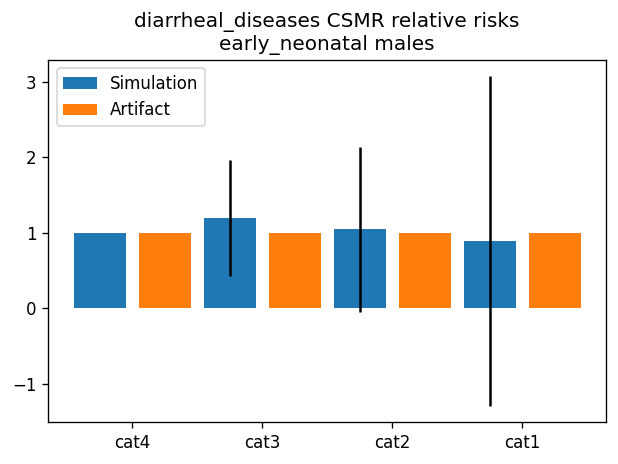

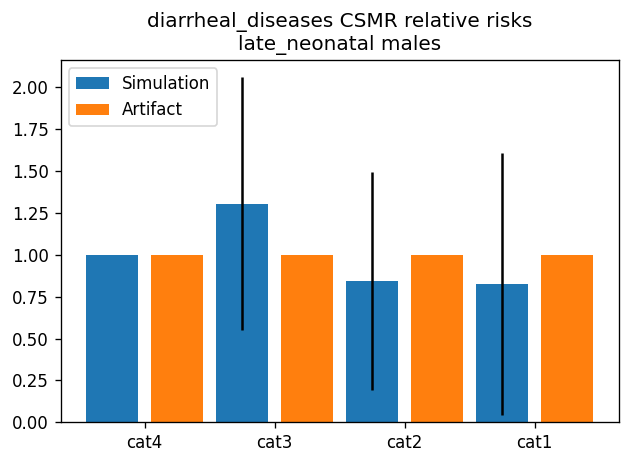

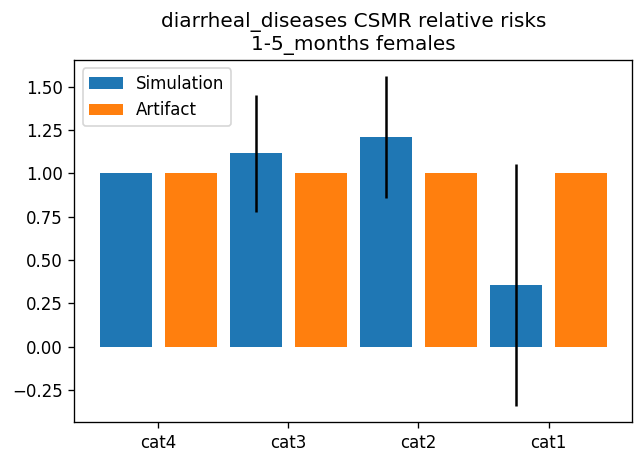

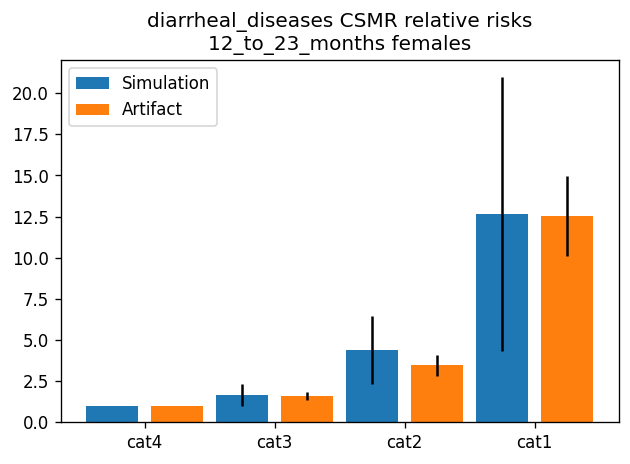

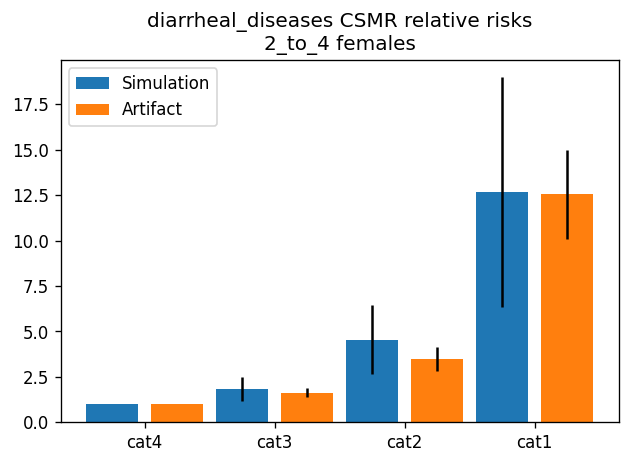

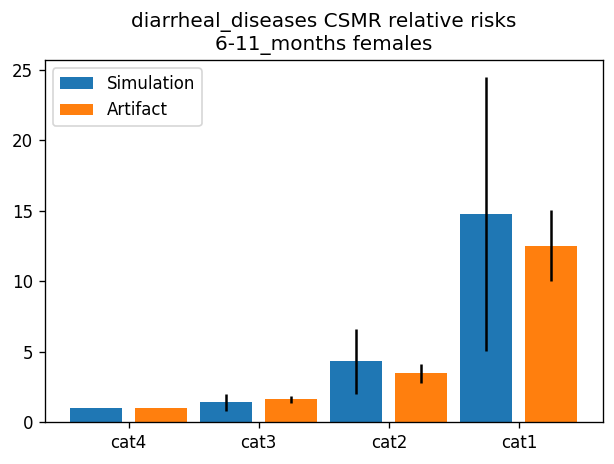

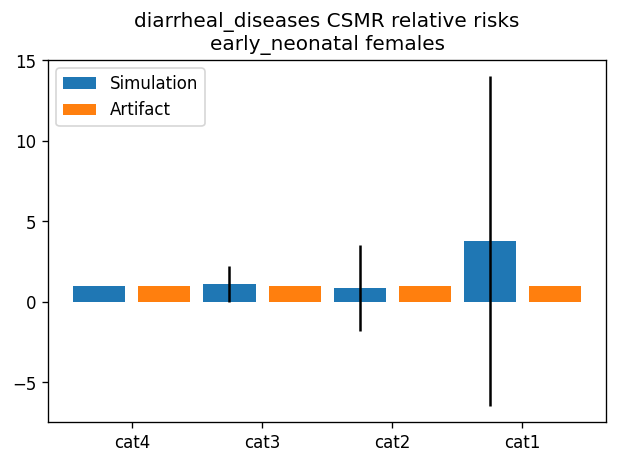

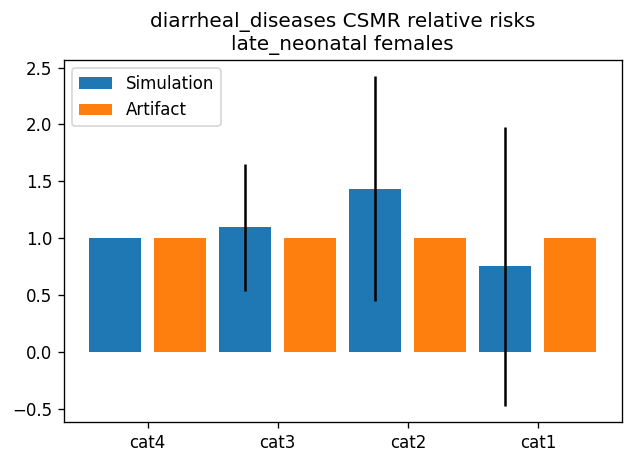

In [30]:
for sex in ['male','female']:
    for age in incidence_rrs.reset_index().age.unique():
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'CSMR')

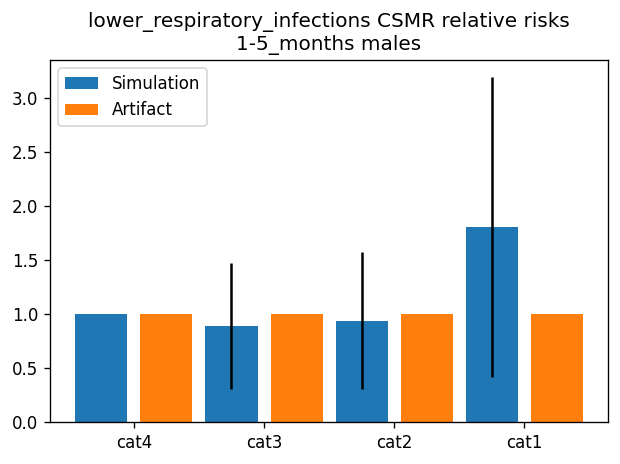

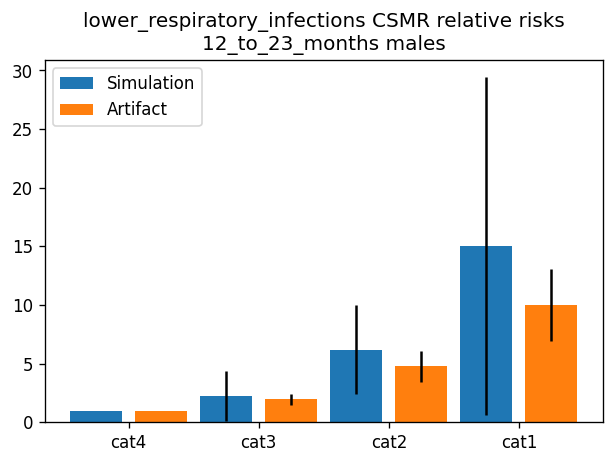

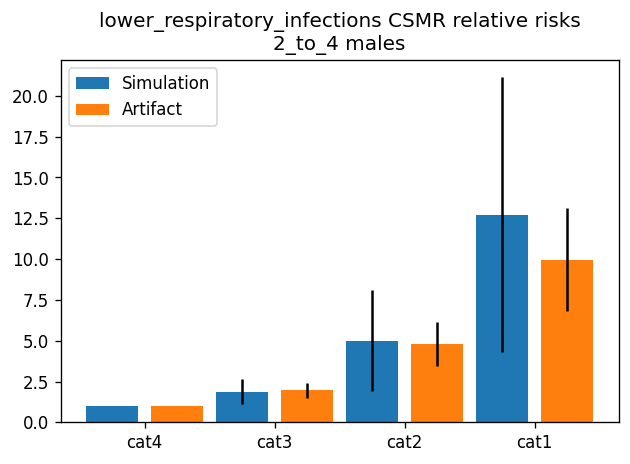

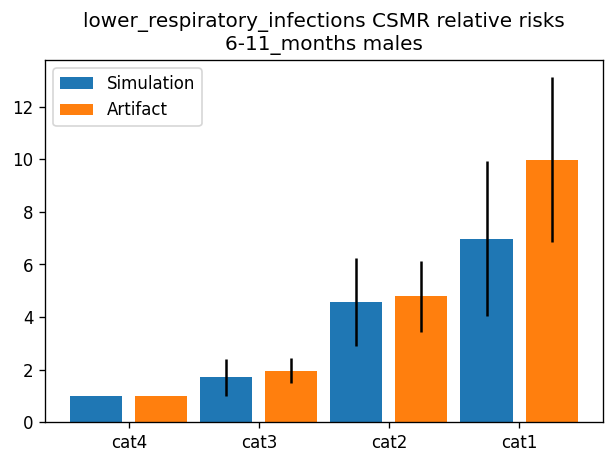

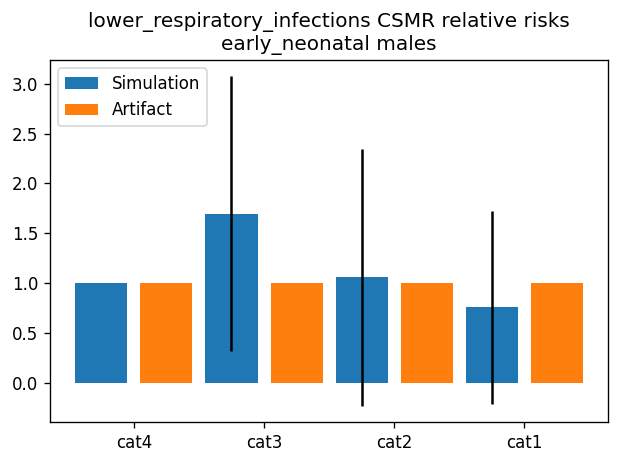

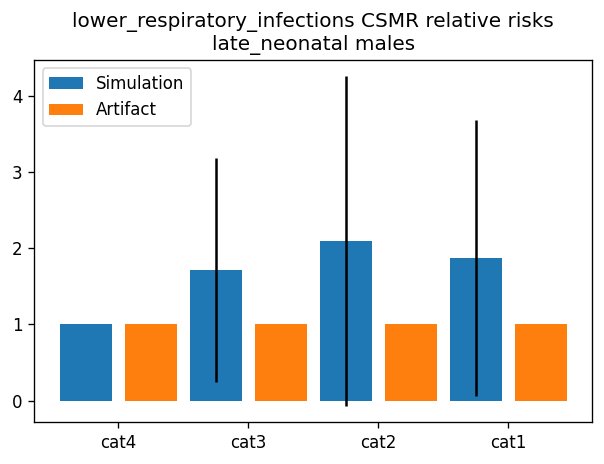

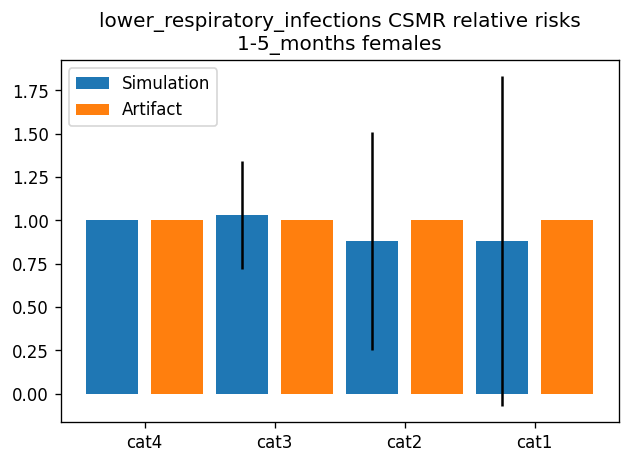

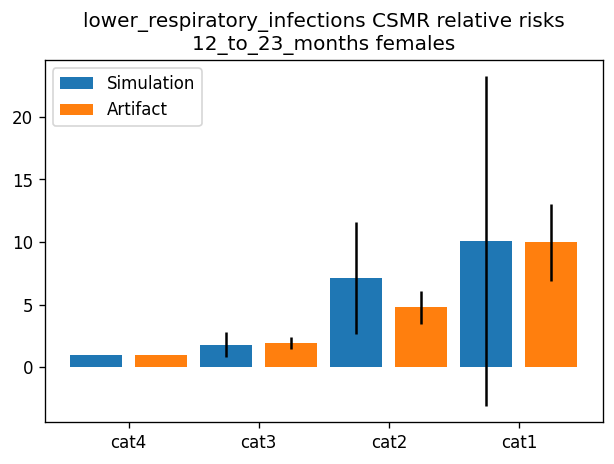

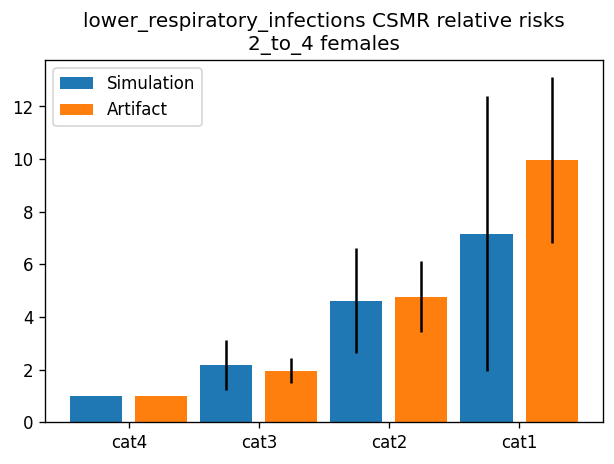

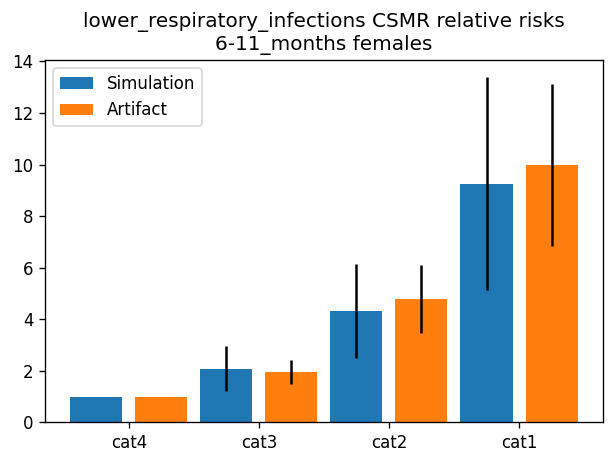

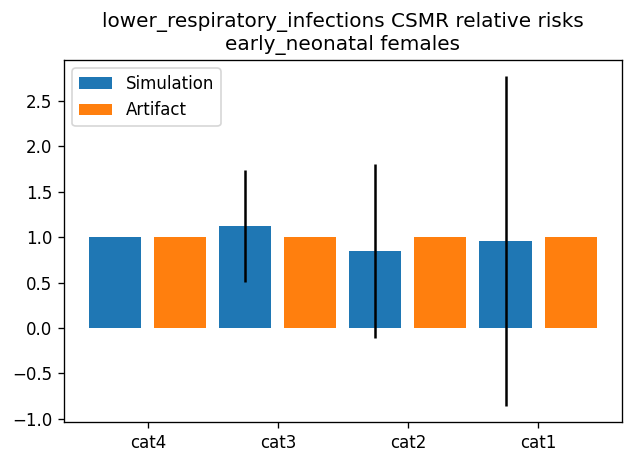

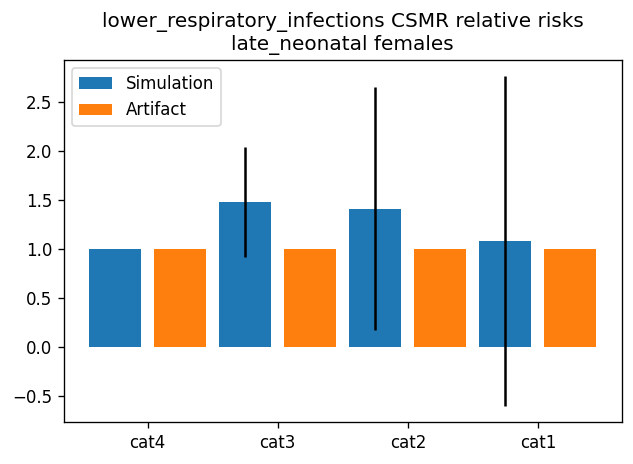

In [31]:
for sex in ['male','female']:
    for age in incidence_rrs.reset_index().age.unique():
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'CSMR')